## **Todo siempre sube**

In [51]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pypfopt.risk_models import risk_matrix
import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
sns.set_palette("dark")

*************
## **Descargando datos**

In [52]:
end = dt.datetime.now()
start =  end - dt.timedelta(days = 365 * 20)

tickers = {
    '^GSPC': 'SP500',  # Estados Unidos (S&P 500)
    '^N225': 'NIKKEI', # Japón (Nikkei 225)
    '^GDAXI': 'DAX',   # Alemanha (DAX)
    '^HSI': 'HSI',     # Hong Kong (Hang Seng Index)
    '^STI': 'STI',     # Singapura (Straits Times Index)
    '^IBEX': 'IBEX'    # Espanha (IBEX 35)
}

# Precios de los indices

indexes = yf.download(tickers= list(tickers.keys()),
                    start= start,
                    end= end)["Close"]
indexes = indexes.resample("M").last()
indexes = indexes.fillna(method = "ffill")
indexes = indexes.rename(columns = tickers)

# Pasamos a dolarés
exchange_rate =  {
    'JPY': 'JPYUSD=X',  # Yen a USD
    'EUR': 'EURUSD=X',  # Euro a USD
    'HKD': 'HKDUSD=X',  # Dólar HK a USD
    'SGD': 'SGDUSD=X'   # Dólar Singapur a USD
}

fx_rates = yf.download(tickers=list(exchange_rate.values()), start=start, end=end)["Close"]
fx_rates = fx_rates.fillna(method="ffill")
fx_rates = fx_rates.resample("M").last()
fx_rates = fx_rates.rename(columns=exchange_rate)

# Crear DataFrame de conversión a USD
conversion_to_usd = pd.DataFrame(index=indexes.index)
conversion_to_usd['SP500'] = 1.0  # Ya está en USD

# Asignar las tasas de cambio correctas a cada índice
conversion_to_usd['NIKKEI'] = fx_rates['JPYUSD=X']
conversion_to_usd['DAX'] = fx_rates['EURUSD=X']
conversion_to_usd['HSI'] = fx_rates['HKDUSD=X']
conversion_to_usd['STI'] = fx_rates['SGDUSD=X']
conversion_to_usd['IBEX'] = fx_rates['EURUSD=X']

indexes = indexes * conversion_to_usd
indexes = indexes.fillna(method="ffill")
indexes

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed


,DAX,HSI,IBEX,NIKKEI,SP500,STI
Date,,,,,,
2005-04-30,3251.876272,1785.146481,6994.786108,105.197332,1156.849976,1298.259076
2005-05-31,3625.349471,1782.353911,7661.809224,104.027578,1191.500000,1297.581077
2005-06-30,3795.332344,1827.701803,8095.986465,104.492243,1191.329956,1313.151316
2005-07-31,4030.768275,1908.601095,8344.131511,105.830664,1234.180054,1416.266391
2005-08-31,3914.800920,1917.767998,8112.904700,112.187979,1220.329956,1353.294834
...,...,...,...,...,...,...
2024-12-31,19132.917233,2583.879382,11142.930752,254.113448,5881.629883,2786.495895
2025-01-31,20903.839349,2595.725013,11897.519902,256.802454,6040.529785,2852.381153
2025-02-28,21696.584642,2949.965299,12841.350813,247.683529,5954.500000,2890.199464


## **Tranformando y visualizando**

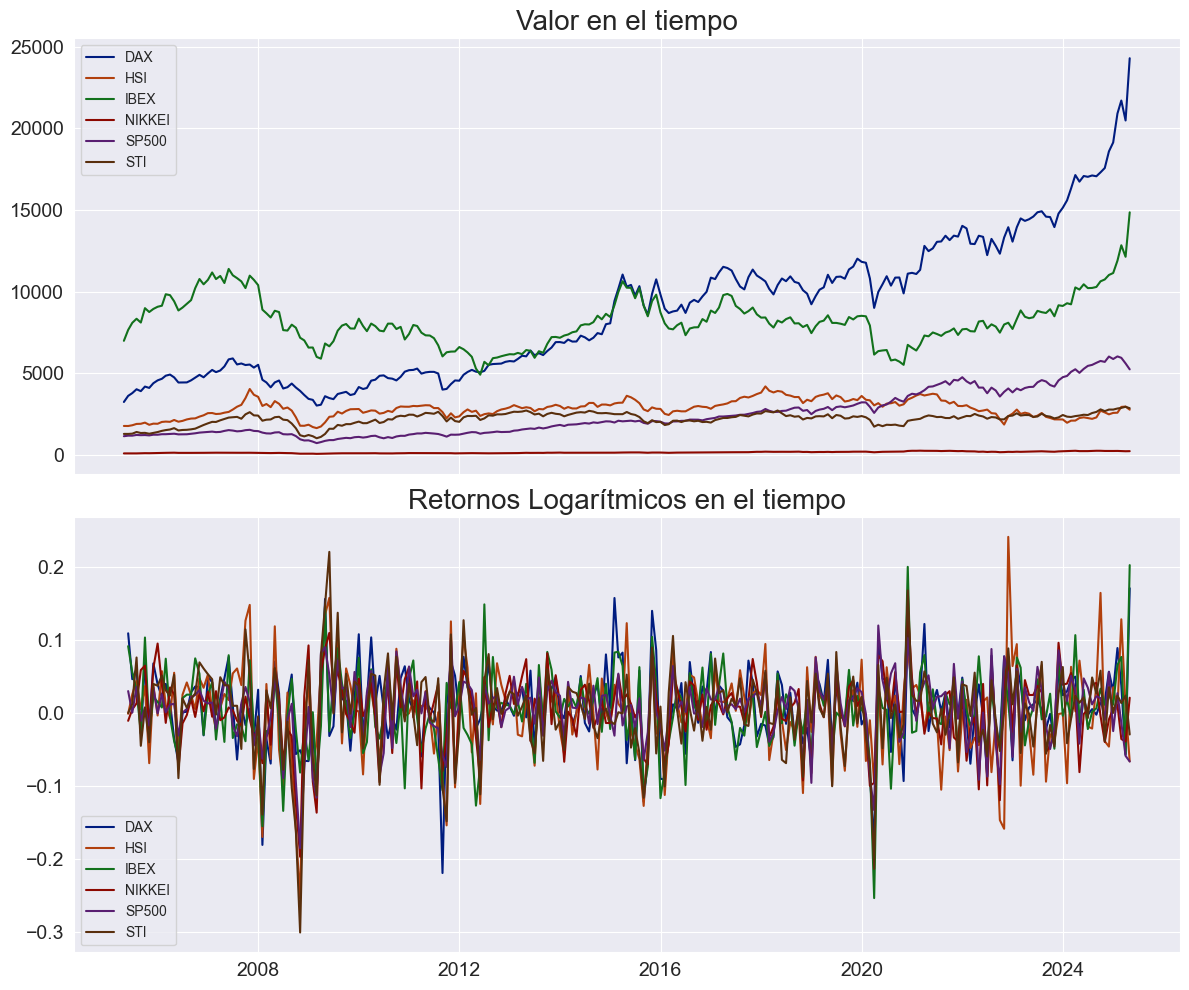

In [53]:
# Retornos logarítmicos
log_returns = np.log(indexes/indexes.shift(1)).dropna()

fig, axes = plt.subplots(ncols=1, nrows= 2, figsize=(12, 10), sharex= True)
sns.lineplot(data = log_returns
            ,dashes = False,
            ax = axes[1]) 
axes[1].set_ylabel("")
axes[1].set_title("Retornos Logarítmicos en el tiempo",
            fontsize = 20)
axes[1].set_xlabel("")
axes[1].tick_params(axis="both", labelsize=14)

sns.lineplot(data = indexes,
            dashes = False,
            ax = axes[0])
axes[0].set_ylabel("")
axes[0].set_title("Valor en el tiempo",
            fontsize = 20)
axes[0].set_xlabel("")
axes[0].tick_params(axis="both", labelsize=14)

sns.lineplot
plt.tight_layout()
plt.show()

## **Crecimiento Anual Compuesto**

$$
\LARGE
CARG = \left(\frac{\text{Valor Final}}{\text{Valor final}}\right)^{(1/n)} - 1
$$

In [54]:
from pypfopt.expected_returns import mean_historical_return

historical_returns = mean_historical_return(prices = indexes,
                                            compounding = True,
                                            frequency = 12)
print(f"Crecimiento Promedio Anual desde {start.date()} hasta {end.date()}\n{"-" * 60}")
for index, i in historical_returns.items():
    print(f"El CARG de {index}: {i:.2%}.")

Crecimiento Promedio Anual desde 2005-04-27 hasta 2025-04-22
------------------------------------------------------------
El CARG de DAX: 10.58%.
El CARG de HSI: 2.24%.
El CARG de IBEX: 3.84%.
El CARG de NIKKEI: 4.27%.
El CARG de SP500: 7.85%.
El CARG de STI: 4.05%.


## **Holding Period Return**
$$
\LARGE
\text{HPR} = \frac{\text{Dividendos} + \text{Valor Final}}{\text{Valor Inicial}} - 1
$$

In [55]:
HPR = (indexes.iloc[-1]/indexes.iloc[0]) - 1

print(f"\tCrecimiento total desde {start.date()} hasta {end.date()}\n{"-" * 70}")
for index, i in HPR.items():
    print(f"El HPR de {index}: {i:.2%}" )
    
print("-" * 70)

for index, i in HPR.items():
    print(f"$100 dolares invertidos en {index} tiene al final un valor de: ${100 * (1 + i):.2f}")

	Crecimiento total desde 2005-04-27 hasta 2025-04-22
----------------------------------------------------------------------
El HPR de DAX: 646.81%
El HPR de HSI: 55.73%
El HPR de IBEX: 112.38%
El HPR de NIKKEI: 130.97%
El HPR de SP500: 353.68%
El HPR de STI: 121.16%
----------------------------------------------------------------------
$100 dolares invertidos en DAX tiene al final un valor de: $746.81
$100 dolares invertidos en HSI tiene al final un valor de: $155.73
$100 dolares invertidos en IBEX tiene al final un valor de: $212.38
$100 dolares invertidos en NIKKEI tiene al final un valor de: $230.97
$100 dolares invertidos en SP500 tiene al final un valor de: $453.68
$100 dolares invertidos en STI tiene al final un valor de: $221.16


## **Volatilidad Para Distintos Periodos de Inversión**

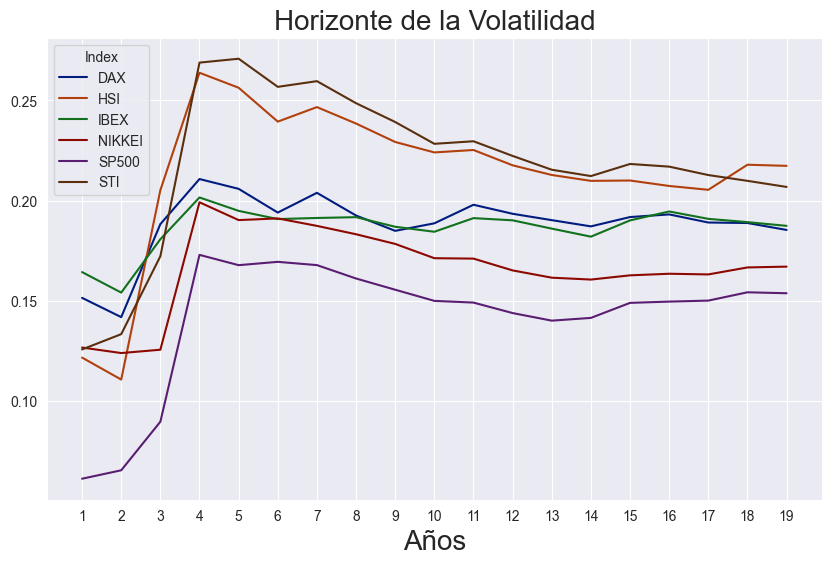

In [56]:
horizon_time = np.arange(12, len(log_returns), 12, dtype = int)
horizon_vol = []

for horizon in horizon_time:
    for index in log_returns:
            vol = log_returns[index].iloc[: horizon].std() * np.sqrt(12)
            horizon_vol.append({"Horizonte": horizon, "Index": index, "Volatilidad": vol})
                
horizon_vol = pd.DataFrame(horizon_vol)
horizon_vol = horizon_vol.pivot( index = "Horizonte",
                                columns= "Index",
								values = "Volatilidad")

horizon_time_years = horizon_time // 12

plt.figure(figsize = (10, 6))
sns.lineplot(horizon_vol,
            dashes = False)
plt.title("Horizonte de la Volatilidad", fontsize = 20)
plt.xlabel("Años", fontsize = 20)
plt.xticks(horizon_time, horizon_time_years)
plt.show()

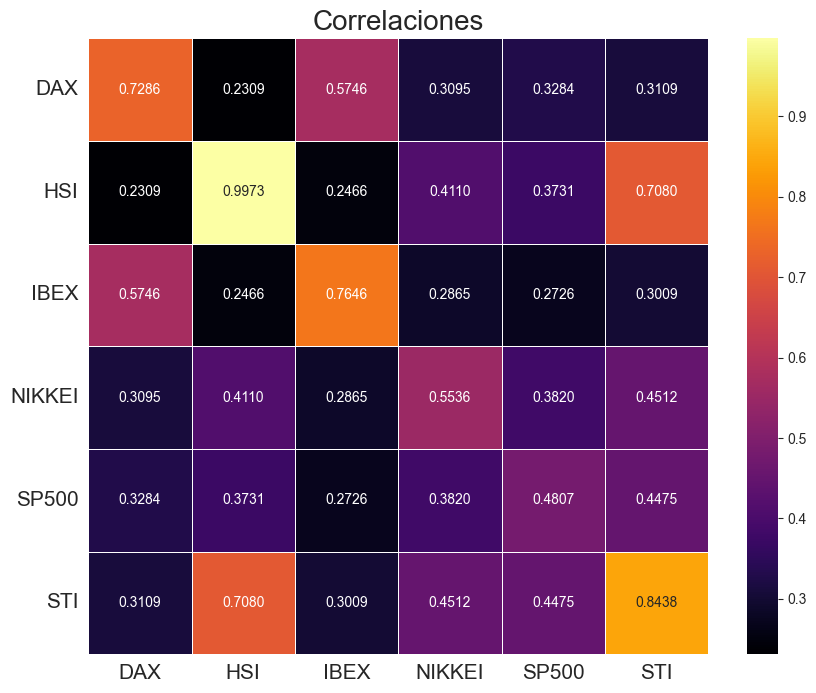

In [57]:
# Matriz de correlaciones
risk = risk_matrix(prices = indexes)
# Crear el mapa de calor de la matriz de riesgo
plt.figure(figsize=(10, 8))
sns.heatmap(risk, annot=True,
            cmap='inferno',
            fmt=".4f", 
            linewidths=.5)
plt.title('Correlaciones',
        fontsize = 20)
plt.yticks(rotation = 0)
plt.tick_params("both", labelsize = 15)
plt.show()

****************
## **Testeando la Estacionaridad: Augmented Dickey-Fuller (ADF)**

### El test ADF se utiliza para comprobar si una serie temporal es **estacionaria** o si contiene una **raíz unitaria** (no estacionaria).

## **Ecuación**

$$
\LARGE
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \varepsilon_t
$$



In [58]:
# ¿Es estacionario los retornos de cada índice?
results_returns = []
for index in log_returns.columns:
    x = indexes[index]
    result = adfuller(x,
                    regression = "c") 
    results_returns.append({"Index": index,
                    "Estadístico": result[0],
                    "P-value": result[1],
                    "Lag Usados:": result[2],
                    "Número de Observaciones": result[3],
        			"Valor Crítico (5%)": result[4]["5%"],
                    "Estacionario": "Sí" if result[1] <= .05 else "No"})

results_returns = pd.DataFrame(results_returns).set_index("Index").round(2)

results_returns

,Estadístico,P-value,Lag Usados:,Número de Observaciones,Valor Crítico (5%),Estacionario
Index,,,,,,
DAX,2.48,1.00,1,239,-2.87,No
HSI,-2.99,0.04,0,240,-2.87,Sí
IBEX,-0.39,0.91,0,240,-2.87,No
NIKKEI,-1.05,0.73,0,240,-2.87,No
SP500,1.28,1.00,15,225,-2.87,No
STI,-2.73,0.07,0,240,-2.87,No


In [59]:
# ¿Es estacionario los precios de cada índice?
results_indexes = []
for index in indexes.columns:
    x = indexes[index]
    result_2 = adfuller(x,
                        regression = "c")
    results_indexes.append({"Index": index,
                    "Estadístico": result_2[0],
                    "P-value": result_2[1],
                    "Lag Usados:": result_2[2],
                    "Número de Observaciones": result_2[3],
        			"Valor Crítico (5%)": result_2[4]["5%"],
                    "Estacionario": "Sí" if result_2[1] <= .05 else "No"})

results_indexes = pd.DataFrame(results_indexes).set_index("Index").round(2)

results_indexes

,Estadístico,P-value,Lag Usados:,Número de Observaciones,Valor Crítico (5%),Estacionario
Index,,,,,,
DAX,2.48,1.00,1,239,-2.87,No
HSI,-2.99,0.04,0,240,-2.87,Sí
IBEX,-0.39,0.91,0,240,-2.87,No
NIKKEI,-1.05,0.73,0,240,-2.87,No
SP500,1.28,1.00,15,225,-2.87,No
STI,-2.73,0.07,0,240,-2.87,No


************
## **Autocorrelación**

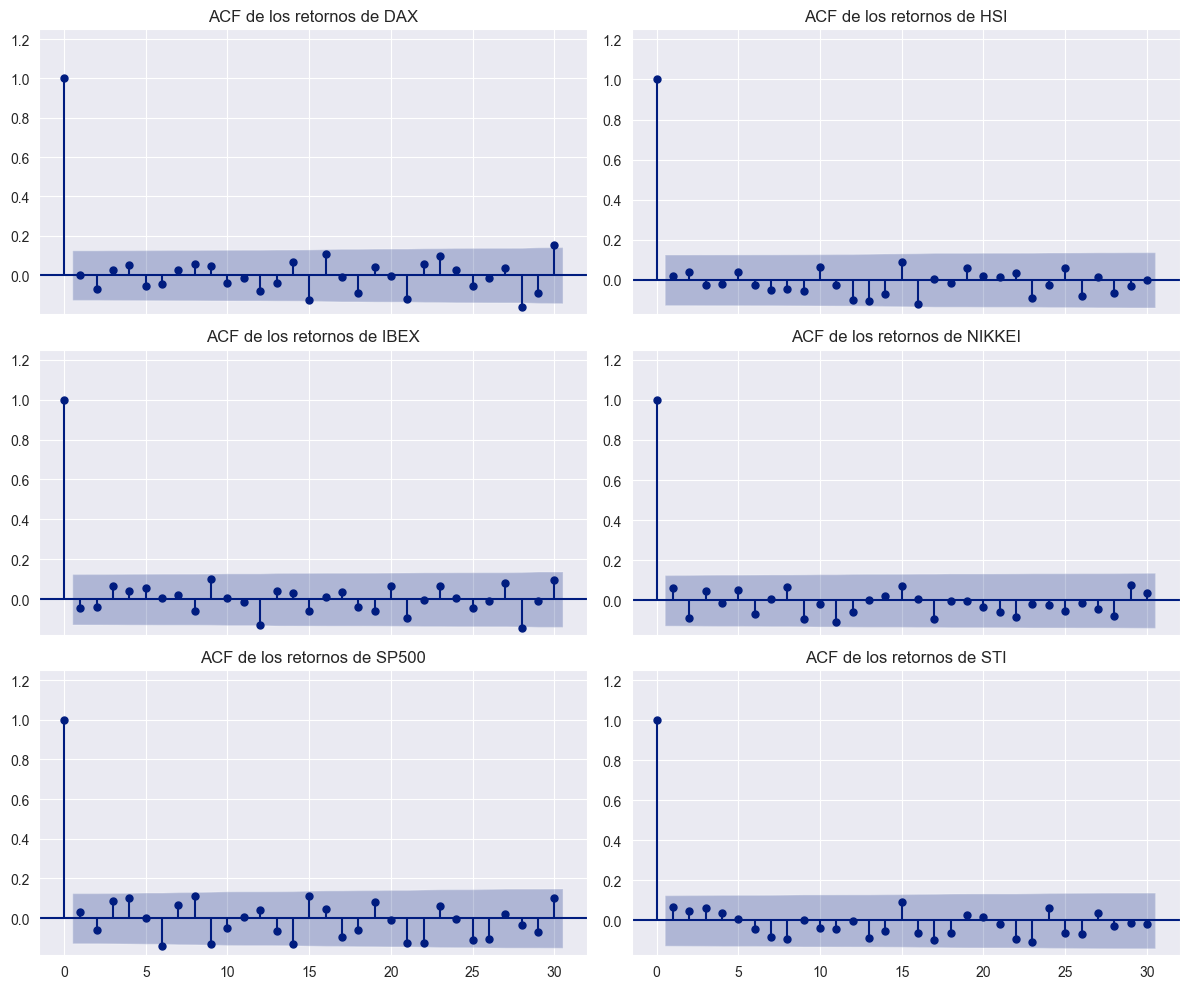

In [60]:
fig2, axes2 = plt.subplots(ncols = 2, nrows = 3, figsize=(12, 10), sharex= True)

for i, col in enumerate(log_returns.columns):
    row = i // 2  # Calcular la fila del subplot
    col_num = i % 2  # Calcular la columna del subplot
    plot_acf(log_returns[col],
            lags = 30, ax = axes2[row, col_num],
            auto_ylims = True)
    axes2[row, col_num].set_title(f"ACF de los retornos de {col}")  # Añadir un título al subplot
plt.tight_layout()
plt.show()

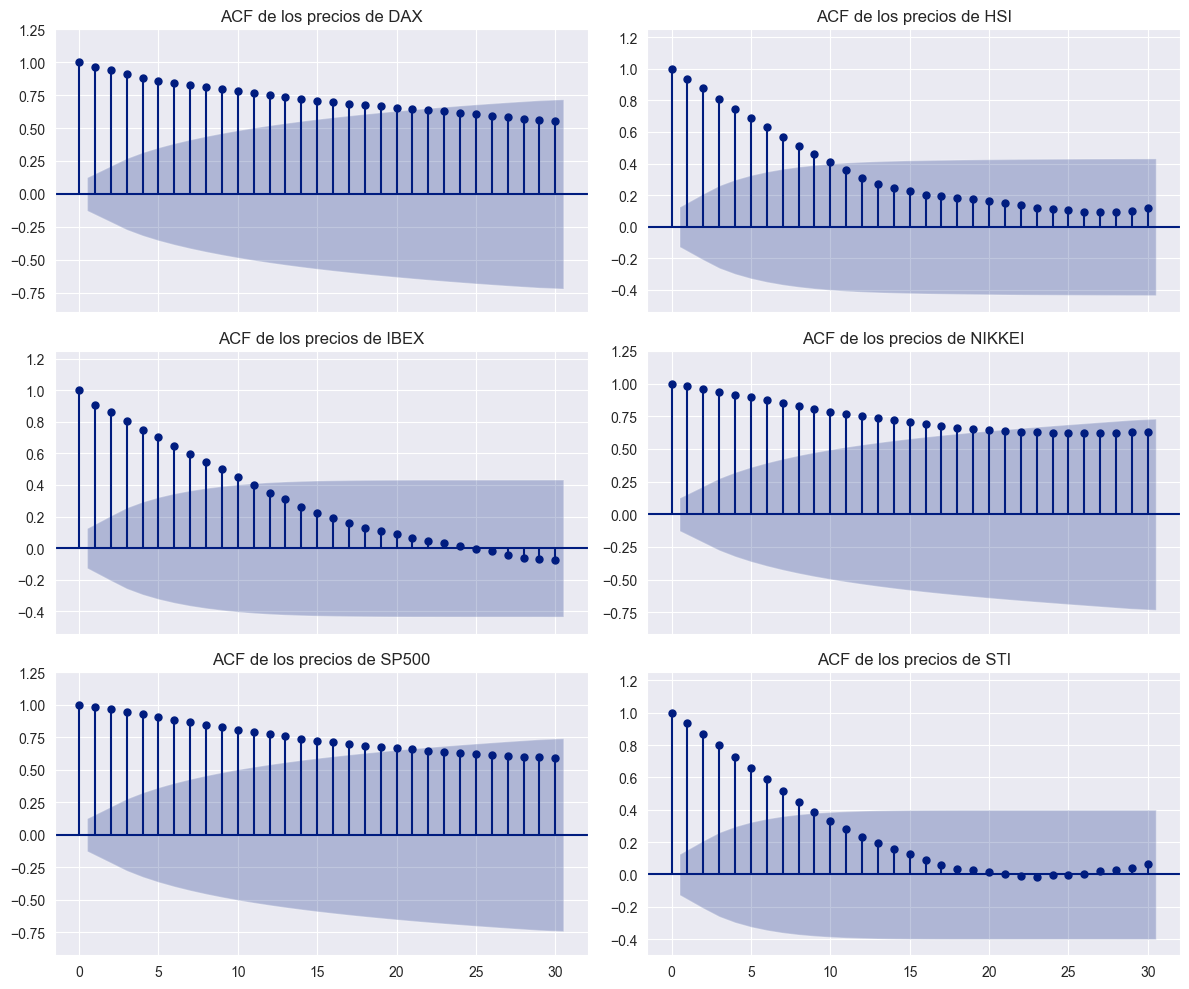

In [61]:
fig3, axes3 = plt.subplots(ncols = 2, nrows = 3, figsize=(12, 10), sharex= True)

for i, col in enumerate(indexes.columns):
    row = i // 2  
    col_num = i % 2  
    plot_acf(indexes[col],
            lags = 30, ax = axes3[row, col_num],
            auto_ylims = True)
    axes3[row, col_num].set_title(f"ACF de los precios de {col}") 
plt.tight_layout()
plt.show()

****
## **Hodrick-Prescott filter**

In [62]:
from statsmodels.tsa.filters.hp_filter import hpfilter


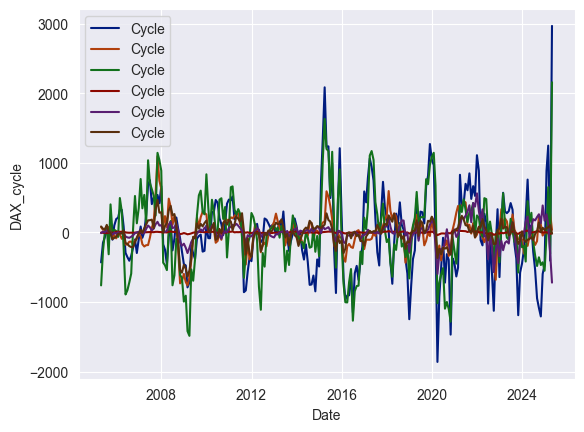

In [ ]:

for index in indexes.columns:
	cycle, trend = hpfilter(x = indexes[index],
						lamb = 1600)
	sns.lineplot(cycle, label = "Cycle")
	plt.plot()